# Load libraries

In [194]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression

import seaborn as sns

In [195]:
include_NER = False

In [196]:
CF = read_datasets.get_configuration()
cs_annotator_names = [key for key in dict(CF.items('m2c_citizen_disease')).keys() if key!='path']
cs_annotator_names.sort()
annotator_names = cs_annotator_names 
if include_NER:
    annotator_names = annotator_names + ['NER_expert']

In [197]:
all_labels = ['Disease', 'Phenotype', 'Both', 'None']

# Load "expert" annotations

In [198]:
def read_expert_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_disease', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-Disease', 'O', 'B-Disease', 'U-Disease', 'L-Disease'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_phenotype', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-phenotype', 'O', 'B-phenotype', 'L-phenotype', 'U-phenotype'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_mixed_annotations(disease_annotations, phenotype_annotations):
    mixed = [disease_annotations['NER_expert'] == 1][0].replace([True, False], [1, 0]) + \
    [phenotype_annotations['NER_expert'] == 1][0].replace([True, False], [2, 0])
    mixed_annotations = pd.DataFrame()
    mixed_annotations = pd.concat([mixed_annotations, disease_annotations['Token']], axis=1)
    #mixed_annotations = pd.concat([mixed_annotations, mixed.replace([0, 1, 2, 3], ['O', 'I-Disease', 'I-Phenotype', 'I-Disease_Pheno'])], axis=1)
    mixed_annotations = pd.concat([mixed_annotations, mixed.replace([0, 1, 2, 3], ['None', 'Disease', 'Phenotype', 'Both'])], axis=1)
    return mixed_annotations
    

In [199]:
expert_disease_annotations = read_expert_disease_annotations()
expert_phenotype_annotations = read_expert_phenotype_annotations()
expert_annotations = read_expert_mixed_annotations(expert_disease_annotations, expert_phenotype_annotations)

# Load all mark2cure citizen scientist annotations

In [200]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_disease', anno_name)
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', anno_name)
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

# Load original annotations

In [201]:
def read_both_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c', anno_name)
        anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
        anno[3].replace(['I-Disease', 'I-Phenotype', 'I-Disease_Pheno', 'O'], \
                        ['Disease', 'Phenotype', 'Both', 'None'], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def sanity_check(annotations, columns, values):
    for col in columns:
        assert set(annotations[col].unique()) == set(values)


In [202]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

In [203]:
mixed_annotations = read_both_annotations()
sanity_check(mixed_annotations, cs_annotator_names, all_labels)

In [204]:
if include_NER:
    mixed_annotations = pd.concat([mixed_annotations, expert_annotations['NER_expert']], axis=1)
    disease_annotations = pd.concat([disease_annotations, expert_disease_annotations['NER_expert']], axis=1)
    phenotype_annotations = pd.concat([phenotype_annotations, expert_phenotype_annotations['NER_expert']], axis=1)

In [205]:
mixed_annotations

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both
1,and,None,None,None,None,None,None
2,abdominal,Disease,Disease,Disease,Both,Disease,Disease
3,aortic,Disease,Disease,Disease,Both,Disease,Disease
4,aneurysm,Disease,Disease,Disease,Both,Disease,Disease
5,.,None,None,None,None,None,None
6,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both
7,and,None,None,None,None,None,None
8,left,Phenotype,Phenotype,None,None,Both,Phenotype
9,loin,Phenotype,Phenotype,None,Phenotype,Both,Phenotype


# Filter relevant rows

In [206]:
def get_relevant_rows(annotations):
    #relevant = annotations[annotator_names] != 'None'
    #relevant = annotations[relevant.all(axis=1)]
    
    relevant = annotations[~(annotations[annotator_names] == 'None').all(axis=1)]
    return relevant

In [207]:
relevant_annotations = get_relevant_rows(mixed_annotations)

In [208]:
disease_annotations = disease_annotations.iloc[relevant_annotations.index]
phenotype_annotations = phenotype_annotations.iloc[relevant_annotations.index]

In [209]:
#disease_annotations = disease_annotations.reset_index()
#phenotype_annotations = phenotype_annotations.reset_index()
relevant_annotations = relevant_annotations.reset_index()
no_nones = {}
nones = {}
for annotator_name in annotator_names:
    no_nones[annotator_name] = relevant_annotations[relevant_annotations[annotator_names] != 'None'].index
    nones[annotator_name] = relevant_annotations[relevant_annotations[annotator_names] == 'None'].index

# Initialize latent variables

In [210]:
K = disease_annotations.shape[0]
J = disease_annotations.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [211]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [212]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
    #for k in annotations.index:
        for j in range(J):
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            #if relevant_annotations[annotator_names[j]][relevant_annotations.index[k]] == 'None':
            #    continue
            if k in nones[annotator_names[j]]:
                continue
            if(annotations[annotator_names[j]][annotations.index[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations[annotator_names[j]][annotations.index[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_annotations
    else:
        annotations = phenotype_annotations
    __resample_z(alpha, beta, z, annotations)

In [213]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        
        Y = z[no_nones[annotator_names[j]], j]
        X = np.vstack((np.ones(len(no_nones[annotator_names[j]])), latent['theta'][no_nones[annotator_names[j]]])).T
        
        #Y = z[:, j]
        #X = np.vstack((np.ones(K), latent['theta'])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)

In [214]:
def resample_theta():
    for k in range(K):
        #Y = latent['d_z'][k, :] - latent['d_alpha'] + latent['p_z'][k, :] - latent['p_alpha']
        #X = latent['d_beta'] + latent['p_beta']
        a = []
        for j in range(len(annotator_names)):
            if k in no_nones[annotator_names[j]]:
                a.append(j)
        a = np.array(a)
        #a = no_nones[annotaor_names[j]]
        
        Y = np.concatenate((latent['d_z'][k, a] - latent['d_alpha'][a], latent['p_z'][k, a] - latent['p_alpha'][a]), axis=0)
        X = np.concatenate((latent['d_beta'][a], latent['p_beta'][a]), axis=0)
        
        #Y = np.concatenate(((latent['d_z'][k, :] - latent['d_alpha']), (latent['p_z'][k, :] - latent['p_alpha'])), axis=0)
        #X = np.concatenate((latent['d_beta'], latent['p_beta']), axis=0)
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))

In [215]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    resample_z('disease')
    resample_z('phenotype')
    resample_theta()
    resample_alpha_beta('disease')
    resample_alpha_beta('phenotype')
    
    save_latent_variables()
    
def has_converged():
    #TODO
    pass
    
def run_sampling(num_iter, thresh, print_freq=50):
    thetas = []
    d_alphas = []
    d_betas = []
    p_alphas = []
    p_betas = []
    for it in xrange(1, num_iter+1):
        resample()
        if it%print_freq == 0:
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
        if it > thresh:
            thetas.append(np.array(latent['theta']))
            d_alphas.append(np.array(latent['d_alpha']))
            p_alphas.append(np.array(latent['p_alpha']))
            d_betas.append(np.array(latent['d_beta']))
            p_betas.append(np.array(latent['p_beta']))

    all_values = {}
    all_values['thetas'] = thetas
    all_values['d_alphas'] = d_alphas
    all_values['d_betas'] = d_betas
    all_values['p_alphas'] = p_alphas
    all_values['p_betas'] = p_betas
    
    return all_values

def get_averages(all_values, num_iter, thresh):
    avg_values = {}
    avg_values['theta'] = np.sum(all_values['thetas'], axis=0)/(num_iter - thresh)
    avg_values['d_alpha'] = np.sum(all_values['d_alphas'], axis=0)/(num_iter - thresh)
    avg_values['d_beta'] = np.sum(all_values['d_betas'], axis=0)/(num_iter - thresh)
    avg_values['p_alpha'] = np.sum(all_values['p_alphas'], axis=0)/(num_iter - thresh)
    avg_values['p_beta'] = np.sum(all_values['p_betas'], axis=0)/(num_iter - thresh)
    return avg_values

In [216]:
np.random.seed(23)
num_iter = 2000
thresh = 300
all_values = run_sampling(num_iter, thresh)
avg_values = get_averages(all_values, num_iter, thresh)

Iter 50/2000 done.
Iter 100/2000 done.
Iter 150/2000 done.
Iter 200/2000 done.
Iter 250/2000 done.
Iter 300/2000 done.
Iter 350/2000 done.
Iter 400/2000 done.
Iter 450/2000 done.
Iter 500/2000 done.
Iter 550/2000 done.
Iter 600/2000 done.
Iter 650/2000 done.
Iter 700/2000 done.
Iter 750/2000 done.
Iter 800/2000 done.
Iter 850/2000 done.
Iter 900/2000 done.
Iter 950/2000 done.
Iter 1000/2000 done.
Iter 1050/2000 done.
Iter 1100/2000 done.
Iter 1150/2000 done.
Iter 1200/2000 done.
Iter 1250/2000 done.
Iter 1300/2000 done.
Iter 1350/2000 done.
Iter 1400/2000 done.
Iter 1450/2000 done.
Iter 1500/2000 done.
Iter 1550/2000 done.
Iter 1600/2000 done.
Iter 1650/2000 done.
Iter 1700/2000 done.
Iter 1750/2000 done.
Iter 1800/2000 done.
Iter 1850/2000 done.
Iter 1900/2000 done.
Iter 1950/2000 done.
Iter 2000/2000 done.


In [217]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
    xa = -(4*alpha - beta*beta)/(4*beta)
    xr = -(4*alpha + beta*beta)/(4*beta)
    return xa, xr

def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, \
                         data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])
    


In [218]:
theta_min = min(avg_values['theta'])
theta_max = max(avg_values['theta'])
print 'theta range: ({}, {})'.format(theta_min, theta_max)

theta range: (-0.0663887920548, 0.077619204102)


In [219]:
relevant_annotations = relevant_annotations.reset_index()

In [220]:
pos = pd.DataFrame()
pos = pd.concat([pos, relevant_annotations[['Token'] + annotator_names]])
pos = pd.concat([pos, pd.Series(avg_values['theta']).rename('theta')], axis=1)
pos

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd,theta
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,0.020861
1,abdominal,Disease,Disease,Disease,Both,Disease,Disease,-0.036265
2,aortic,Disease,Disease,Disease,Both,Disease,Disease,-0.025244
3,aneurysm,Disease,Disease,Disease,Both,Disease,Disease,0.004725
4,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,-0.034422
5,left,Phenotype,Phenotype,None,None,Both,Phenotype,-0.012530
6,loin,Phenotype,Phenotype,None,Phenotype,Both,Phenotype,-0.005879
7,pain,Phenotype,Phenotype,Both,Phenotype,Both,Phenotype,-0.033888
8,abdominal,Disease,Disease,Disease,Both,Disease,Disease,0.000829
9,aortic,Disease,Disease,Disease,Both,Disease,Disease,0.010427


In [221]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    #pos_annos = pos_annos[pos_annos[annotator] == 'Phenotype']
    pos_annos = pos_annos[pos_annos[annotator] != 'None']
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, data=pos_annos, \
                         hue_order=['Disease', 'Both', 'Phenotype'], \
                         palette={'Disease':'green', 'Phenotype':'red', 'Both':'blue'}, s=75)
    ax.get_yaxis().set_visible(False)
    ax.set_title(annotator + ' labels')
    ax.arrow(-2.6, 0, 7.1, 0, head_width=0.00006, head_length=0.00002, width=0.000002, fc='brown', ec='brown') 
    ax.set_xlabel('Disease-Phenotype spectrum')
    #ax.set(xticks=[-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5])

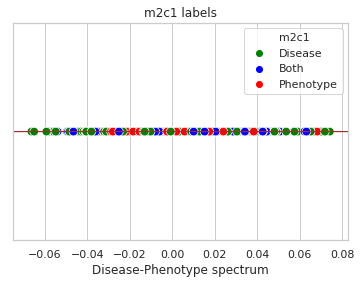

In [222]:
plot_thetas(pos, annotator_names[0])

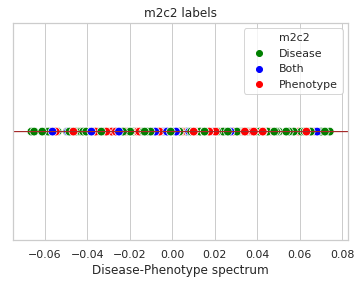

In [223]:
plot_thetas(pos, annotator_names[1])

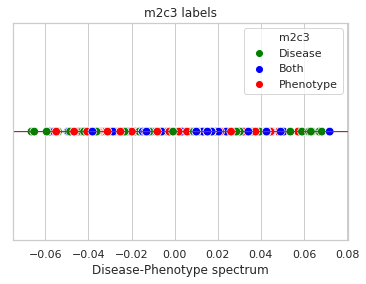

In [224]:
plot_thetas(pos, annotator_names[2])

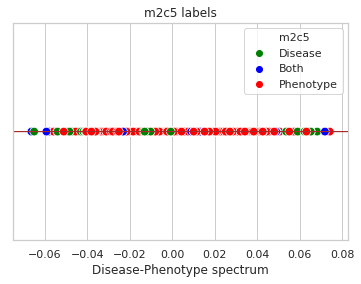

In [225]:
plot_thetas(pos, annotator_names[3])

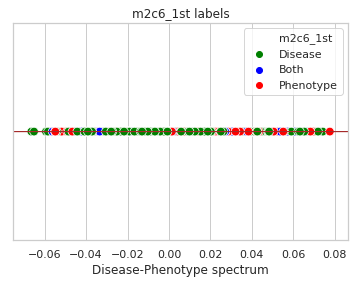

In [226]:
plot_thetas(pos, annotator_names[4])

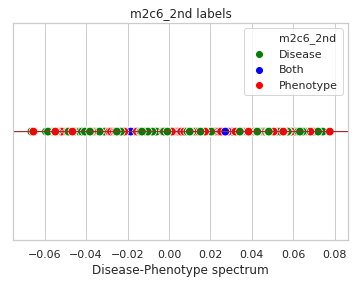

In [227]:
plot_thetas(pos, annotator_names[5])

In [229]:
#plot_thetas(pos, annotator_names[6])

In [230]:
xda, xdr = get_annotator_bias(avg_values['d_alpha'], avg_values['d_beta'])

In [231]:
xpa, xpr = get_annotator_bias(avg_values['p_alpha'], avg_values['p_beta'])

In [232]:
xda - xdr

array([-0.00027652, -0.00035104, -0.00030408, -0.00025703,  0.00010912,
        0.00035562])

In [233]:
xpa - xpr

array([ 3.77852067e-04,  8.99565917e-04,  3.74524561e-05, -3.99737507e-04,
        3.62303163e-04,  2.02537742e-04])

In [234]:
(xda + xdr)/2

array([ 2.56544937e-03, -2.34134011e-02, -6.30505342e-01, -1.51043527e+00,
       -3.26229673e+00,  9.36884941e-01])

In [235]:
(xpa + xpr)/2

array([  0.01665395,  -0.22136025, -11.79511402,   0.09948415,
        -0.4346276 ,  -1.2755453 ])

In [236]:
loc_pd = pd.DataFrame()
loc_pd['xda'] = xda
loc_pd['xdr'] = xdr
loc_pd['xpa'] = xpa
loc_pd['xpr'] = xpr
loc_pd['annotator'] = annotator_names

In [237]:
loc_pd

,xda,xdr,xpa,xpr,annotator
0,0.002427,0.002704,0.016843,0.016465,m2c1
1,-0.023589,-0.023238,-0.220910,-0.221810,m2c2
2,-0.630657,-0.630353,-11.795095,-11.795133,m2c3
3,-1.510564,-1.510307,0.099284,0.099684,m2c5
4,-3.262242,-3.262351,-0.434446,-0.434809,m2c6_1st
5,0.937063,0.936707,-1.275444,-1.275647,m2c6_2nd


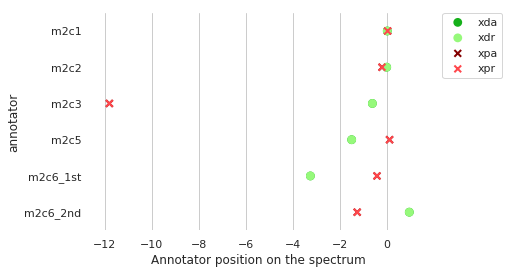

In [243]:
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = annotator_names

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['annotator'] = annotator_names
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [239]:
dis_loc = (xda + xdr)/2
phe_loc = (xpa + xpr)/2

phe_loc - dis_loc

array([  0.0140885 ,  -0.19794685, -11.16460868,   1.60991943,
         2.82766914,  -2.21243024])

[-3616.42035004 -2848.66246858 -3288.56865786 -3890.5811503
  9163.96817161  2812.00888254]


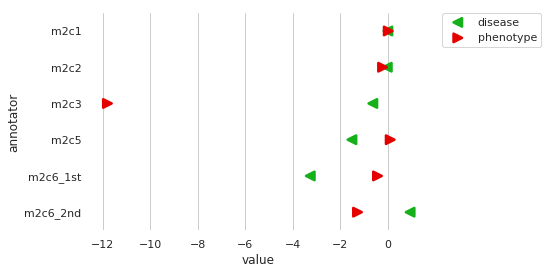

In [240]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

dis_phe_pd

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=["<", ">"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
#ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max), 0.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

dis_inverses = 1/(xda - xdr)
print(dis_inverses)

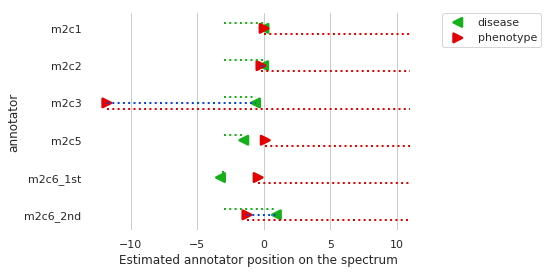

In [244]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=["<", ">"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

i = 0
for annotator in annotator_names:
    #annotator = 'Annotator{}'.format(i+1)
    dis = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'disease')]['value']
    
    phe = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'phenotype')]['value']
    
    plt.plot([max(dis.sum()-5, -3), dis.sum()], [i-0.15, i-0.15], sns.xkcd_rgb["green"], lw=2, linestyle=':')
    plt.plot([phe.sum(), max(phe.sum()+5, 11)], [i+0.15, i+0.15], sns.xkcd_rgb["red"], lw=2, linestyle=':')
    if phe.sum() < dis.sum():
        plt.plot([phe.sum(), dis.sum()], [i, i], sns.xkcd_rgb["blue"], lw=2, linestyle=':')
    i += 1

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
#ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Text(0,0.5,'Bias estimate for disease')

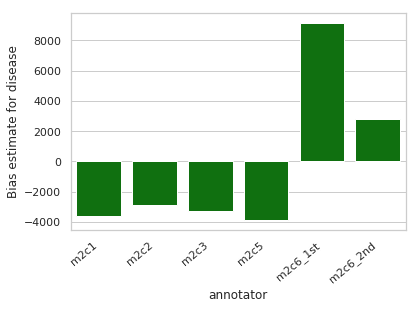

In [245]:
dis_inverses = 1/(xda - xdr)

dis_inverses_pd = pd.DataFrame()
dis_inverses_pd['error_bar'] = dis_inverses
dis_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="error_bar", data=dis_inverses_pd, color="green")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Bias estimate for disease')

Text(0,0.5,'Bias estimate for phenotype')

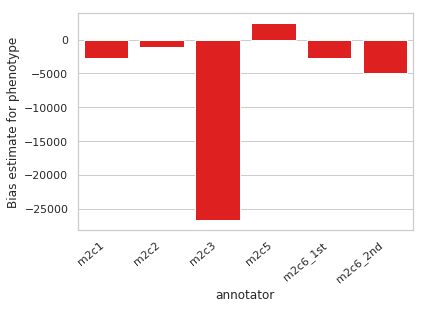

In [246]:
phe_inverses = 1/(xpr - xpa)

phe_inverses_pd = pd.DataFrame()
phe_inverses_pd['error_bar'] = phe_inverses
phe_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="error_bar", data=phe_inverses_pd, color="red")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_ylabel('Bias estimate for phenotype')

In [247]:
def plot_theta_tokens(pos_annos):
    pos_theta = pos[['Token', 'theta']]
    pos_theta['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", data=pos_theta)

Text(0.5,0,'Disease-Phenotype spectrum')

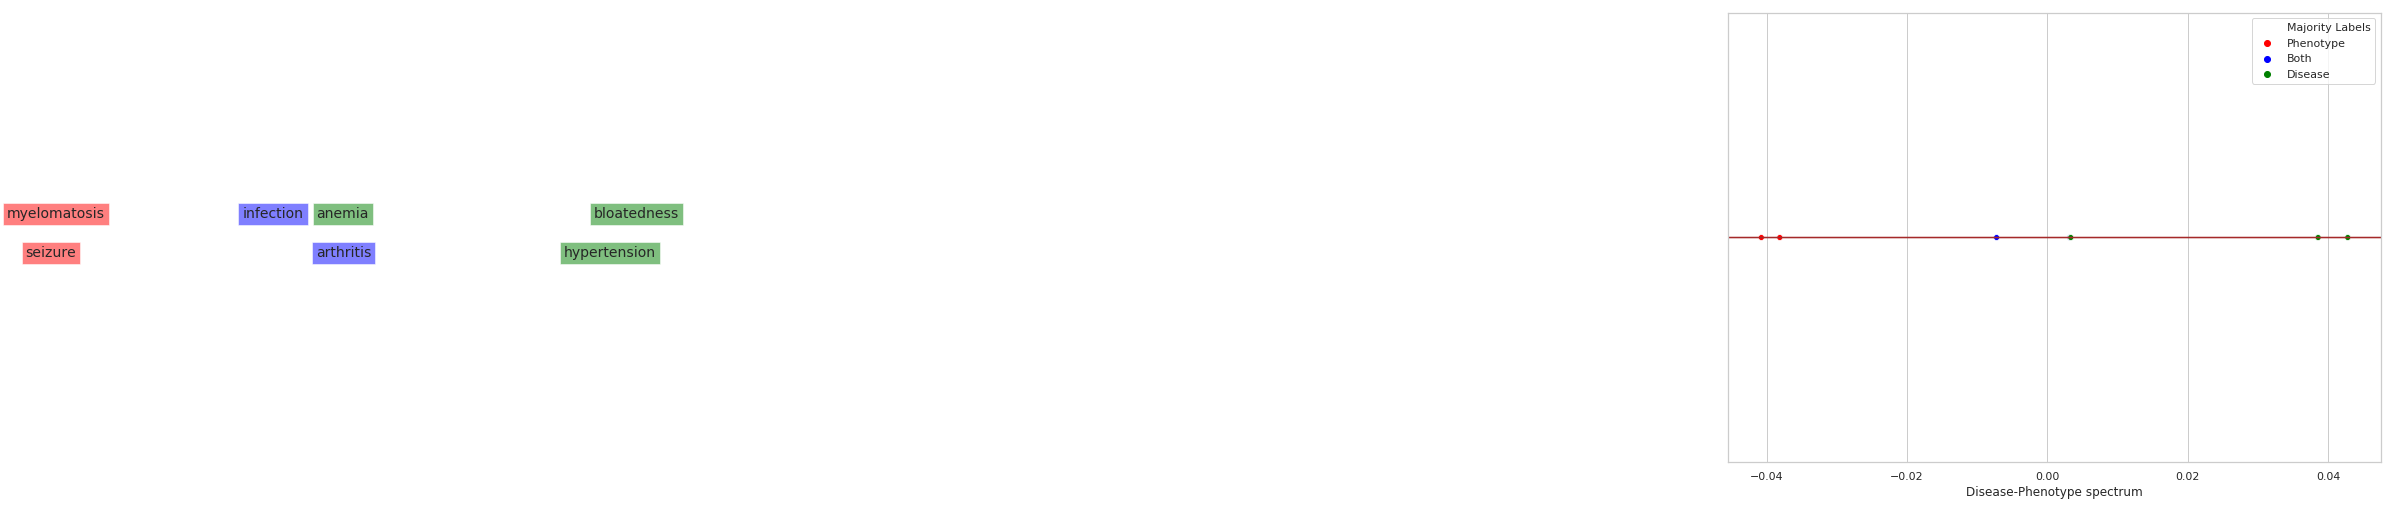

In [248]:
new_pos = pos[(pos['Token'] == 'bloatedness') | (pos['Token'] == 'seizure') | (pos['Token'] == 'infection') | (pos['Token'] == 'arthritis') | (pos['Token'] == 'hypertension') | (pos['Token'] == 'anemia') | (pos['Token'] == 'myelomatosis')].drop_duplicates(['Token'])
new_pos.sort_values('theta', inplace=True)
new_pos['Majority Labels'] = ['Phenotype', 'Phenotype', 'Both', 'Both', 'Disease', 'Disease', 'Disease']

new_pos.reset_index()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

palette={'Disease':'green', 'Phenotype':'red', 'Both':'blue'}
ax = sns.scatterplot(x="theta", y="zeros", data=new_pos, hue="Majority Labels", \
                     palette=palette) #, \
                     #hue_order=['Disease', 'Both', 'Phenotype'])

ax.get_yaxis().set_visible(False)

mult = 1
pick = {'Disease':'green', 'Phenotype':'red', 'Both':'blue'}
for index, row in new_pos.iterrows():
    color = pick[row['Majority Labels']]
    ax.text(row['theta']-0.25, 0.00007*mult, row['Token'], bbox = dict(facecolor=color, alpha=0.5), fontsize=14)
    mult *= -1
    
ax.arrow(-2.6, 0, 4.1, 0, head_width=0.00006, head_length=0.00002, width=0.000002, fc='brown', ec='brown') 
ax.set_xlabel('Disease-Phenotype spectrum')


In [249]:
def count_relevant_stats(relevant_annotations, annotator, label):
    return relevant_annotations[relevant_annotations[annotator] == label][annotator].count()

In [250]:
def get_relevant_stats(relevant_annotations, annotator):
    print 'Statistics for {}'.format(annotator)
    total = float(len(relevant_annotations))
    print 'Percentage of Disease labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'Disease')/total)
    print 'Percentage of Phenotype labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'Phenotype')/total)
    print 'Percentage of both labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'Both')/total)

In [251]:
for annotator in annotator_names:
    get_relevant_stats(relevant_annotations, annotator)
    print

Statistics for m2c1
Percentage of Disease labels: 0.311111111111
Percentage of Phenotype labels: 0.0864864864865
Percentage of both labels: 0.0768768768769

Statistics for m2c2
Percentage of Disease labels: 0.338738738739
Percentage of Phenotype labels: 0.132732732733
Percentage of both labels: 0.0366366366366

Statistics for m2c3
Percentage of Disease labels: 0.234834834835
Percentage of Phenotype labels: 0.115915915916
Percentage of both labels: 0.0876876876877

Statistics for m2c5
Percentage of Disease labels: 0.178978978979
Percentage of Phenotype labels: 0.194594594595
Percentage of both labels: 0.113513513514

Statistics for m2c6_1st
Percentage of Disease labels: 0.415615615616
Percentage of Phenotype labels: 0.267267267267
Percentage of both labels: 0.115915915916

Statistics for m2c6_2nd
Percentage of Disease labels: 0.483483483483
Percentage of Phenotype labels: 0.375975975976
Percentage of both labels: 0.0276276276276



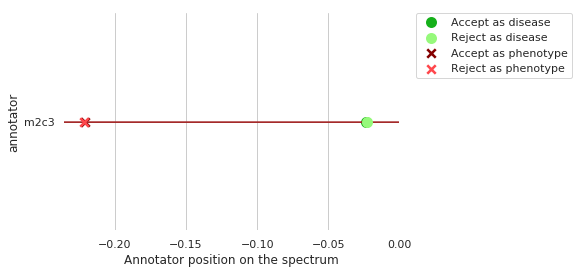

In [252]:
dis_pd = pd.DataFrame()
dis_pd['Accept as disease'] = xda[1:2]
dis_pd['Reject as disease'] = xdr[1:2]
dis_pd['annotator'] = ['m2c2']

phe_pd = pd.DataFrame()
phe_pd['Accept as phenotype'] = xpa[1:2]
phe_pd['Reject as phenotype'] = xpr[1:2]
phe_pd['annotator'] = ['m2c3']
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1.25, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1.25, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-2.6, 0.002, 8.1, 0.002, fc='brown', ec='brown') 

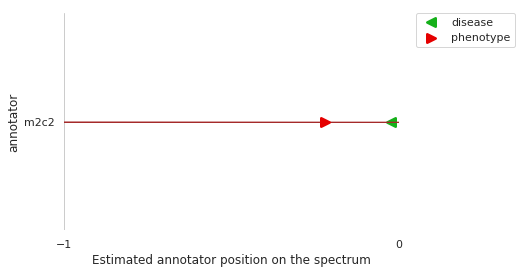

In [254]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc[1:2]
dis_phe_pd['phenotype'] = phe_loc[1:2]
dis_phe_pd['annotator'] = ['m2c2']

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=["<", ">"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-3.1, 0.002, 4.1, 0.002, fc='brown', ec='brown') 

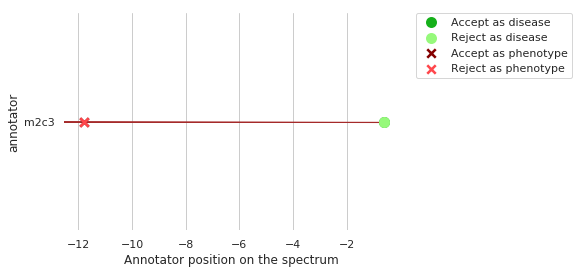

In [257]:
dis_pd = pd.DataFrame()
dis_pd['Accept as disease'] = xda[2:3]
dis_pd['Reject as disease'] = xdr[2:3]
dis_pd['annotator'] = ['m2c3']

phe_pd = pd.DataFrame()
phe_pd['Accept as phenotype'] = xpa[2:3]
phe_pd['Reject as phenotype'] = xpr[2:3]
phe_pd['annotator'] = ['m2c3']
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1.25, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1.25, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-12.6, 0.002, 12.1, 0.002, fc='brown', ec='brown') 

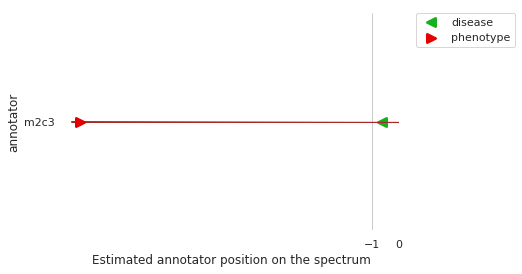

In [262]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc[2:3]
dis_phe_pd['phenotype'] = phe_loc[2:3]
dis_phe_pd['annotator'] = ['m2c3']

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=["<", ">"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-12.1, 0.002, 12.1, 0.002, fc='brown', ec='brown') 

In [263]:
pos

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd,theta,zeros
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,0.020861,0
1,abdominal,Disease,Disease,Disease,Both,Disease,Disease,-0.036265,0
2,aortic,Disease,Disease,Disease,Both,Disease,Disease,-0.025244,0
3,aneurysm,Disease,Disease,Disease,Both,Disease,Disease,0.004725,0
4,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,-0.034422,0
5,left,Phenotype,Phenotype,None,None,Both,Phenotype,-0.012530,0
6,loin,Phenotype,Phenotype,None,Phenotype,Both,Phenotype,-0.005879,0
7,pain,Phenotype,Phenotype,Both,Phenotype,Both,Phenotype,-0.033888,0
8,abdominal,Disease,Disease,Disease,Both,Disease,Disease,0.000829,0
9,aortic,Disease,Disease,Disease,Both,Disease,Disease,0.010427,0


In [264]:
(theta_min + theta_max)/2

0.005615206023626647

In [265]:
nrelevant_annotations = get_relevant_rows(mixed_annotations)
npos = pd.DataFrame()
npos = pd.concat([npos, mixed_annotations[['Token']]])
npos['theta'] = None
npos.loc[nrelevant_annotations.index, 'theta'] = avg_values['theta']
npos

,Token,theta
0,Haematuria,0.0208611
1,and,None
2,abdominal,-0.036265
3,aortic,-0.0252438
4,aneurysm,0.00472523
5,.,None
6,Haematuria,-0.0344219
7,and,None
8,left,-0.0125301
9,loin,-0.00587901


In [243]:
def get_new_labels(pos_annos, theta_thresh):
    new_labels = pd.DataFrame()
    new_labels = pd.concat([new_labels, pos_annos['Token']])
    new_labels['col1'] = '?'
    new_labels['col2'] = '?'
    new_labels['Label'] = 'O'
    new_labels.loc[(pos_annos['theta'] < theta_thresh), 'Label'] = 'I-phenotype'
    return new_labels

In [244]:
#import importlib
reload(read_datasets)
def save_new_labels(pos_annos, theta_thresh):
    new_labels = get_new_labels(pos_annos, theta_thresh)
    new_file = os.path.join(read_datasets.get_dataset_folder(), CF.get('m2c_new_labels', 'path'), 'm2c_new_labels_{}.txt'.format(theta_thresh))
    new_labels.to_csv(new_file, sep=' ', index=False, header=False)
    new_labels[new_labels['Label'] == 'I-phenotype'].count()

In [245]:
#save_new_labels(npos, (theta_min + theta_max)/2) #midpoint of all theta values.
#save_new_labels(npos, phe_loc[1]) #phenotype threshold for m2c2 (our best annotator)

In [247]:
nl = get_new_labels(npos, phe_loc[1])
nl[nl['Label'] == 'I-phenotype'].count()

0        127
col1     127
col2     127
Label    127
dtype: int64

In [249]:
#npos.to_csv('theta_values_with_expert.txt', index=False)

In [250]:
#zz = pd.read_csv('theta_values_with_expert.txt')

In [257]:
#max(zz['theta'])

1.3392647500663601

In [258]:
theta_max

1.33926475006636

In [259]:
#zz

,Token,theta
0,Haematuria,-1.343101
1,and,NaN
2,abdominal,0.445600
3,aortic,0.377792
4,aneurysm,0.365013
5,.,NaN
6,Haematuria,-1.367967
7,and,NaN
8,left,NaN
9,loin,NaN


In [261]:
dis_loc

array([-1.39382186, -0.65279188, -1.10769207, -0.44203619, -1.89207974,
       -2.04912153, -6.74965515])